In [1]:
import torch
from torch import nn
import numpy as np
import aet_net
import aet_dyn
from sklearn.manifold import TSNE
import optuna
from collections import OrderedDict

# get CUDA index
DEVICE = torch.cuda.current_device()

import matplotlib.pyplot as plt
from itertools import combinations


plt.rcParams["figure.figsize"] = (15,5)

In [2]:
# NN building blocks

def sigmoid(z):

    return 1.0/(1.0+torch.exp(-2*(z)))

class CNN_q_comp(nn.Module):
    
    def __init__(self, in_channels, out_channels, quadrant_size = 28, learn_bias=True):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size=quadrant_size,stride=quadrant_size,bias=learn_bias)    
        self.nonlin = sigmoid
        self.pool = torch.sum
        
    def forward(self,input):
        
        x = self.conv(input)
        x = self.pool(x,dim=(-2,-1))
        y = self.nonlin(x)
        
        return y

class FC_layer(nn.Module):
    def __init__(self, in_channels, out_channels, actifun, learn_bias=True):
        super().__init__()

        self.fc = nn.Linear(in_channels, out_channels)    
        self.nonlin = actifun
        
    def forward(self,input):
        
        x = self.nonlin(self.fc(input))

        return x

In [3]:
# sparsity regularizer

def bias_regularizer(model,data,kl_reg_,dims):
        
        DEVICE = torch.cuda.current_device()
        _beta, _rho = kl_reg_
        
        rho_hat = torch.zeros((dims[1],)).to(DEVICE)
        
        for inp in data:
            
            H = model.CONV_QCOMP.forward(inp)
            
            # calculate hidden activations
            rho_hat += H
        
        rho_hat /= data.shape[0]
        
        # regularizer: KL divergence between hidden activations & rho (added to loss)
        regu_loss = _beta*torch.sum(_rho*torch.log(_rho/rho_hat) + (1-_rho)*torch.log((1-_rho)/(1-rho_hat)))
        
        # penalty bias gradient
        regu_bias = _beta * (-_rho/rho_hat + ((1-_rho)/(1-rho_hat)))
        
        return regu_loss, regu_bias
    
# training function
    
def train_model(model,dims,data,output,num_ep,kl_reg_,optimizer,criterion):

    loss_epo = torch.zeros((num_ep,))
    accu_epo = torch.zeros((num_ep,))
    for e in range(num_ep):

        shuff_idx = np.random.permutation(data.shape[0])

        for i in range(len(shuff_idx)):

            # forward
            y = model(data[shuff_idx[i]])

            regu_loss, regu_bias = bias_regularizer(model,data,kl_reg_,dims)

            optimizer.zero_grad()

            # loss + sparsity penalty
            _loss = criterion(output[shuff_idx[i]],y) + regu_loss

            # accumulate gradients for minibatch
            _loss.backward()
            #print("  Val1: ",model.CONV_QCOMP.conv._parameters['bias'].grad[0])
            model.CONV_QCOMP.conv._parameters['bias'].grad += regu_bias 
            #print("  Val2: ",model.CONV_QCOMP.conv._parameters['bias'].grad[0])
            
             # update after mini batch
            optimizer.step()

        loss_epo[e] = _loss
        accu_epo[e] = torch.mean(y[output[shuff_idx[i]].to(bool)])
    
    return loss_epo, accu_epo

Optimize learning params with optua


In [4]:
data,output = aet_net.aet_stim.mkstim()
data = data.to(DEVICE)
output = output.to(DEVICE)

In [5]:
def objective(trial):
    
    num_epo_ = 100

    criterion = nn.MSELoss()

    # to be optimized params
    N_HIDNODE =  68#trial.suggest_int('size_hid:', 128,256,32)# suggest
    eta_ = .15
    BETA_ = trial.suggest_float('BETA_:',0.0001,0.01)
    P_ = trial.suggest_float('P_',1e-5,1e-3)


    kl_reg_ = [BETA_,P_]#[0,0.001]lay_size_ = [56, 254, 10]

    lay_size_ = [56, N_HIDNODE, 3]
    model = nn.Sequential(OrderedDict([
        ('CONV_QCOMP', CNN_q_comp(data.shape[1], lay_size_[1])),
        ('FC1', FC_layer(lay_size_[1], lay_size_[2],nn.Softmax(dim=-1)))]))


    model = model.to(DEVICE)

    optimizer = torch.optim.SGD(model.parameters(),lr=eta_)

    # train model
    loss_hist,accu_hist = train_model(model,lay_size_,data,output,num_epo_,kl_reg_,optimizer,criterion)
    
    # "tangledness" of hidden represenations
    
    idx = np.array((0,5,10))#,-1))
    inp_combi = list(combinations(idx,2))           # possible input combinations
    all_angle_sum = torch.zeros(len(inp_combi))

    for i,c in enumerate(inp_combi):

        H1 = data[c[0]]
        H2 = data[c[1]]
        H3 = data[c[0]]+data[c[1]]

        # apply layer
        H1 = model.CONV_QCOMP.forward(H1)
        H2 = model.CONV_QCOMP.forward(H2)
        H3 = model.CONV_QCOMP.forward(H3)

        H1_2 = H1+H2


        num_ = torch.matmul(H3,H1_2)
        denom_ = torch.linalg.vector_norm(H3)*torch.linalg.vector_norm(H1_2)
        all_angle_sum[i] = (torch.acos(num_/denom_)*180/torch.pi).cpu().detach()

    # minimize loss & tangledness
    return loss_hist[-1] + torch.sum(all_angle_sum)

In [6]:
# find optimal learning parameters with optuna

optuna.logging.set_verbosity(optuna.logging.WARN)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  4.1622490882873535
  Params: 
    BETA_:: 0.008647755276826692
    P_: 0.0006062462773143778


Best trial:
  Value:  5.438484191894531
  Params: 
    BETA_:: 0.009202993200531563
    P_: 0.0007219022315138953

# **Train on AET problem**

In [7]:
# stimuli
data,output = aet_net.aet_stim.mkstim()
data = data.to(DEVICE)
output = output.to(DEVICE)

# initialize model
#nn_dim_ = [28,64,4]
mini_sz_ = 1
num_epo_ = 200

criterion = nn.MSELoss()

# to be optimized params
N_HIDNODE = 68# suggest


# optimal parameters (optuna)
eta_ = 0.15
BETA_ = 0.009
P_ = 7e-4

kl_reg_ = [BETA_,P_]#[0,0.001]lay_size_ = [56, 254, 10]

lay_size_ = [56, N_HIDNODE, 3]
model = nn.Sequential(OrderedDict([
        ('CONV_QCOMP', CNN_q_comp(data.shape[1], lay_size_[1])),
        ('FC1', FC_layer(lay_size_[1], lay_size_[2],nn.Softmax(dim=-1)))]))


model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(),lr=eta_)

loss_hist = train_model(model,lay_size_,data,output,num_epo_,kl_reg_,optimizer,criterion)

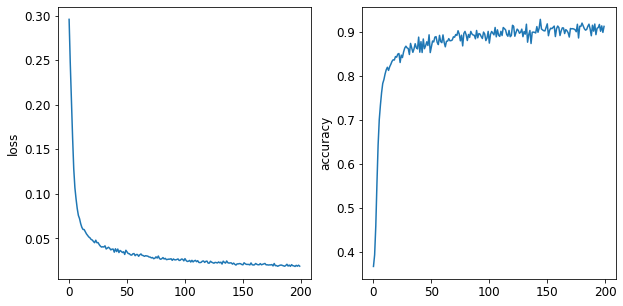

In [8]:
# plot loss
plt.rcParams["figure.figsize"] = (10,5)
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font',**font)
fig, ax = plt.subplots(1,2)
ax[0].plot(loss_hist[0].detach().cpu().numpy())
ax[0].set_ylabel('loss')
ax[1].plot(loss_hist[1].detach().cpu().numpy())
ax[1].set_ylabel('accuracy')

plt.savefig('loss_accu.png')


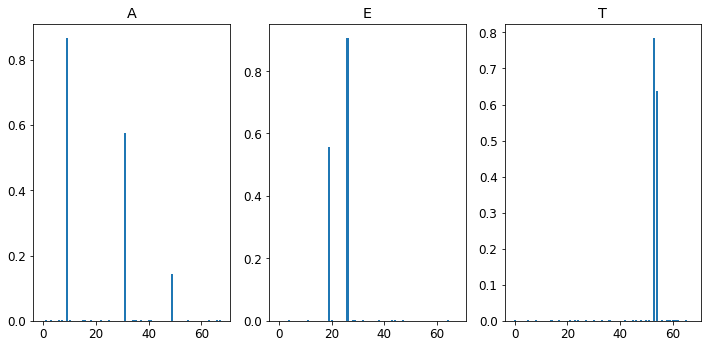

In [9]:
# plot hidden activations


# subset of inputs
idx = np.array((0,5,10))#,-1))
data_sub = data[idx]
#label = ['A','E','T','Z']
label = ['A','E','T']

fig, axs = plt.subplots(1,3)
axs = axs.ravel()

for i,ax in enumerate(axs):
    H = model.CONV_QCOMP.forward(data_sub[i])
    
    ax.bar(np.arange(lay_size_[1]),H.cpu().detach().numpy())
    ax.set_title(label[i])
    
fig.tight_layout()
plt.savefig('hidden_acti.png')


**Dynamics in hidden layer**

In [10]:
def euler_dyn(model,lay_size,input_,params_,t_,alpha_params,DEVICE,inp_on):

    # inputs:
        # input_: input image
        # params_: dynamics parameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude
        # DEVICE: cuda index
        # inp_on: time point at which input is turned on (for boxcar) in ms

    # discretization & dynamics parameters
    tau_h,tau_R,R,T,h_start,R_start = params_


    # alpha frequency & amplitude
    _af,_aa = alpha_params

    with torch.no_grad():

        # initialize empty matrices
        dt = np.diff(t_)[0]
        dhdt = (torch.ones((lay_size[1],len(t_)+1))*h_start).to(DEVICE)
        dRdt = (torch.ones((lay_size[1],len(t_)+1))*R_start).to(DEVICE)
        dOdt = (torch.zeros((lay_size[2],len(t_)+1))).to(DEVICE)
        dZdt = (torch.zeros((lay_size[1],len(t_)+1))).to(DEVICE)

        # alpha inhibition
        alpha_inh = _aa*np.sin(2*np.pi*_af*t_)+_aa

        # preactivation (dot product of input and first weight matrix)
        Z = model.CONV_QCOMP.pool(model.CONV_QCOMP.conv(input_),dim=(-2,-1))

        
        # create boxcar function to try different input onsets
        boxcar = np.zeros_like(t_)
        boxcar[inp_on:] = 1

        # adjust initial adaptation term (threshold)
        dRdt *= torch.max(Z)                           

        # scale for adaptation
        r_scale = R*torch.max(Z).detach()


        for _it,t in enumerate(t_):

            # dynamic input: multiply input with boxcar
            Z = model.CONV_QCOMP.pool(model.CONV_QCOMP.conv(input_*boxcar[_it]),dim=(-2,-1))
            
            # pre-activation
            dZdt[:,_it+1] = (Z + dhdt[:,_it] - dRdt[:,_it] - alpha_inh[_it])/T

            # dynamics hidden layer
            dhdt[:,_it+1] = dhdt[:,_it] + dt/tau_h * (-dhdt[:,_it] + model.CONV_QCOMP.nonlin(dZdt[:,_it+1]))      

            # adaptation term
            dRdt[:,_it+1] = dRdt[:,_it] + dt/tau_R * (-dRdt[:,_it] + r_scale*dhdt[:,_it+1])

            # output layer
            dOdt[:,_it+1] = model.FC1.forward(dhdt[:,_it+1])

    return dZdt, dhdt, dRdt, dOdt

In [11]:
# # apply dynamics to hidden layer

# for a in range(10):
#     alpha_params = [0,0]
#     dyn_params = [0.01,0.05,a,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
#     _io = 0
#     timevec = np.linspace(0,0.6,600)
#     dyn_params = [0.01,0.05,a,0.05,0,1]

#     Zt,Ht,Rt,Ot = euler_dyn(model,lay_size_,data[0],dyn_params,timevec,alpha_params,DEVICE,_io)

#     # plot
#     fig,ax = plt.subplots(3,1)
#     ax[2].plot(Ot.T.cpu().detach().numpy())
#     ax[2].legend(('A(t)','E(t)','T(t)'),loc='lower right')
#     #ax[2].set_title('output')

#     ax[1].plot(Rt.T.cpu().detach().numpy())
#     #ax[1].set_title('relaxation')
#     ax[0].plot(Ht.T.cpu().detach().numpy())
#     ax[0].set_title('a'+str(a))

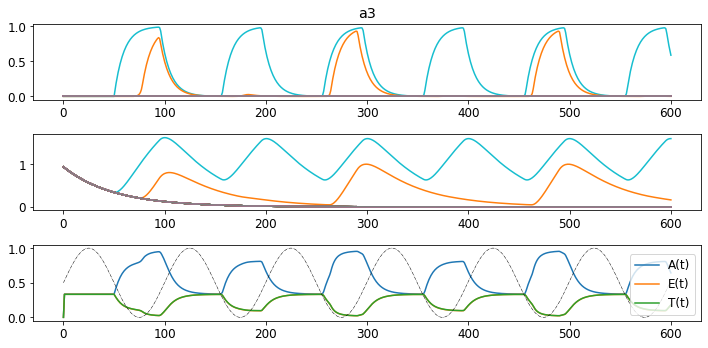

In [12]:
a = 3
alpha_params = [10,0.5]
dyn_params = [0.01,0.05,a,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
_io = 50
timevec = np.linspace(0,0.6,600)
dyn_params = [0.01,0.05,a,0.05,0,1]

Zt,Ht,Rt,Ot = euler_dyn(model,lay_size_,data[0],dyn_params,timevec,alpha_params,DEVICE,_io)

# plot
fig,ax = plt.subplots(3,1)
ax[2].plot(Ot.T.cpu().detach().numpy())
ax[2].legend(('A(t)','E(t)','T(t)'),loc='lower right')
#ax[2].set_title('output')

ax[1].plot(Rt.T.cpu().detach().numpy())
#ax[1].set_title('relaxation')
ax[0].plot(Ht.T.cpu().detach().numpy())
ax[0].set_title('a'+str(a))
alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
ax[2].plot(alpha_inh,'k',linewidth=0.5,linestyle='-.')

fig.tight_layout()

In [13]:
# good hyperparams identified below - find optimum P

**Explore dynamics hyperparams**


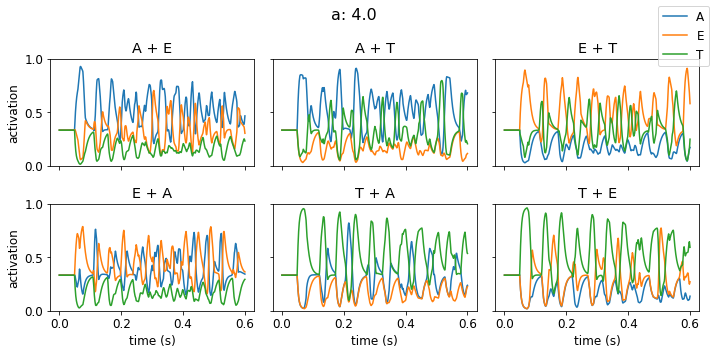

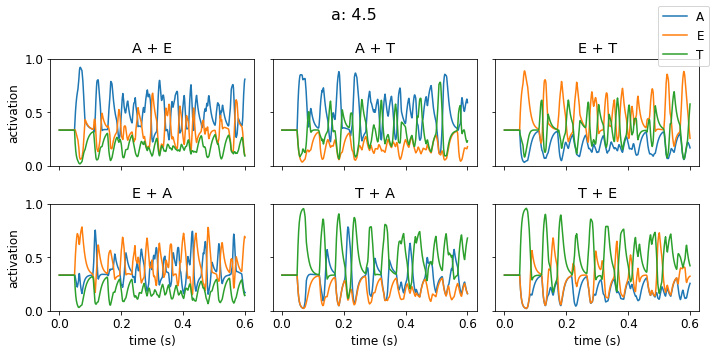

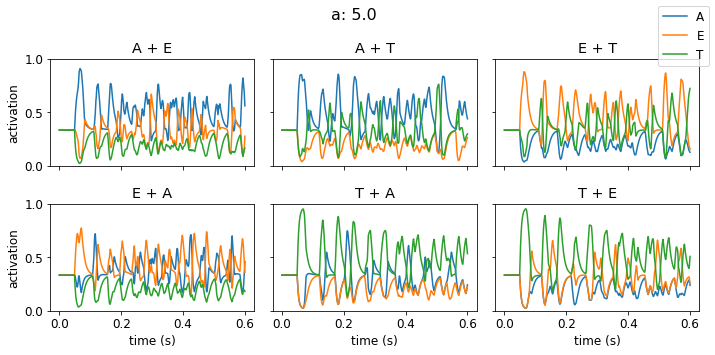

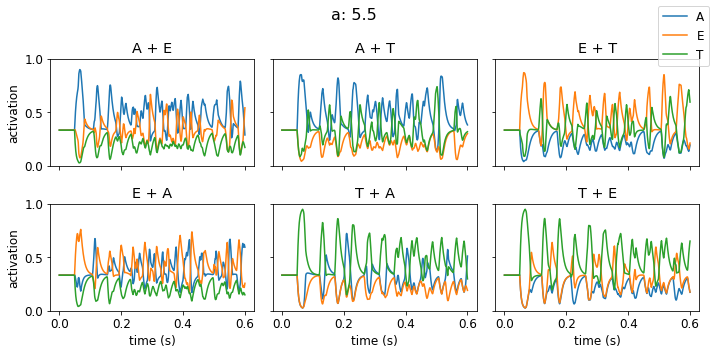

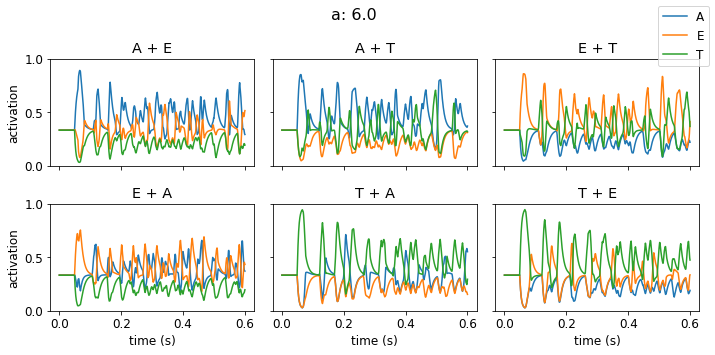

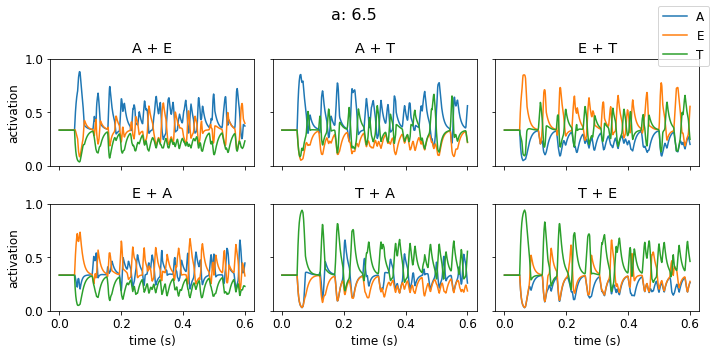

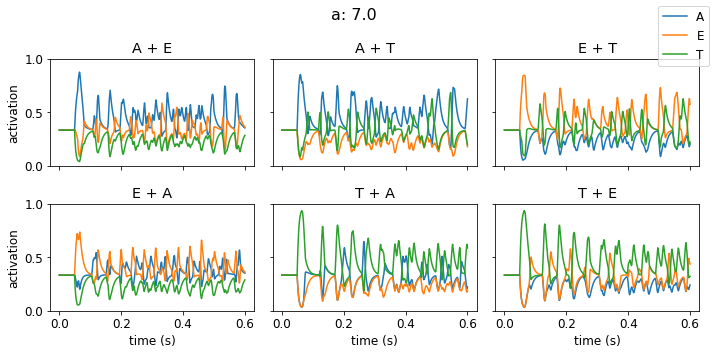

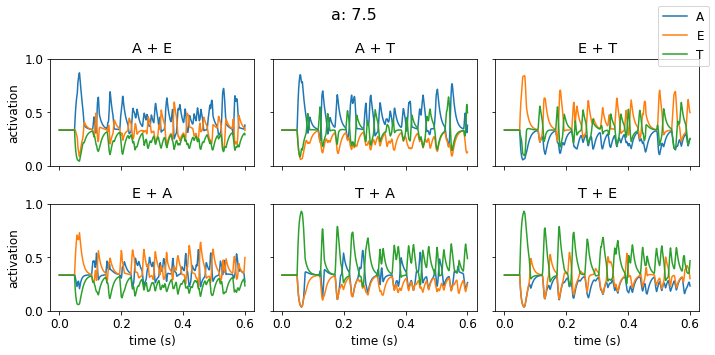

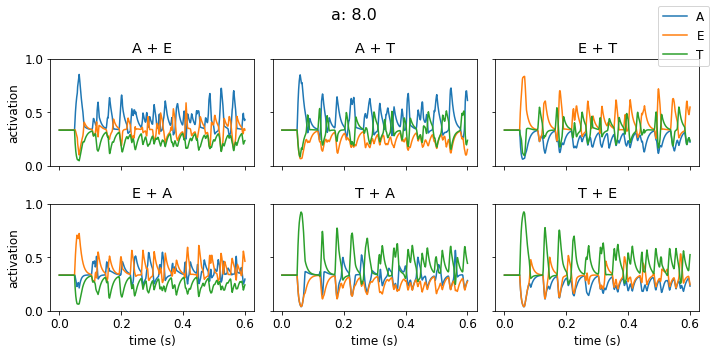

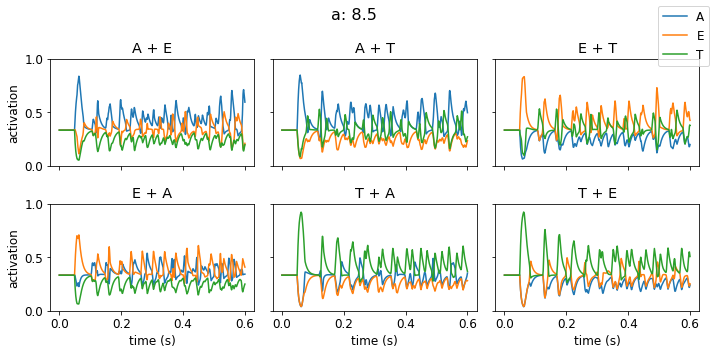

In [14]:
for a in np.arange(4,9,0.5):
    alpha_params = [10,0.5]

    alpha_params = [0,0]
    dyn_params = [0.01,0.1,a,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
    _io = 50
    timevec = np.linspace(0,0.6,600)

    fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
    #ax = ax.ravel()
    plt.setp(ax,yticks=np.arange(0,1.5,0.5))

    ax[0][0].set_ylabel('activation')
    ax[1][0].set_ylabel('activation')

    alpha_inh = alpha_params[1]*np.sin(2*np.pi*timevec*alpha_params[0])+alpha_params[1]

    inp_combi = list(combinations(idx,2))           # possible input combinations
    x_train = data

    fig.suptitle('a: '+ str(a), fontsize=16)

    for i,comp_inp in enumerate(inp_combi):
        input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
        _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

        ax[0][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)

        if alpha_params[1]:
            ax[0][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
        ax[0][i].set_ylim((0,1))
        fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
        ax[0][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])

    for i,comp_inp in enumerate(inp_combi):
        input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
        _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

        ax[1][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
        if alpha_params[1]:
            ax[1][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
        ax[1][i].set_ylim((0,1))
        fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
        ax[1][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
        ax[1][i].set_xlabel('time (s)')

    fig.legend((label))
    fig.tight_layout()



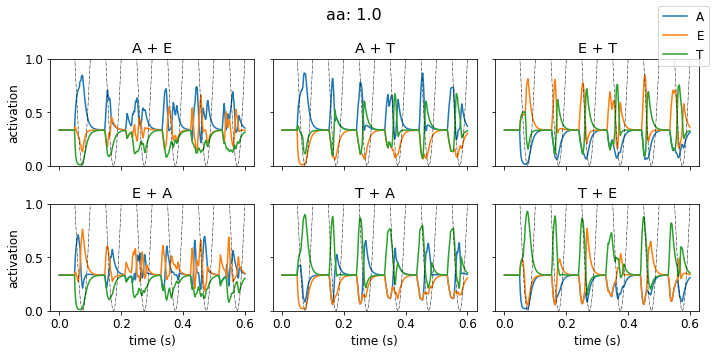

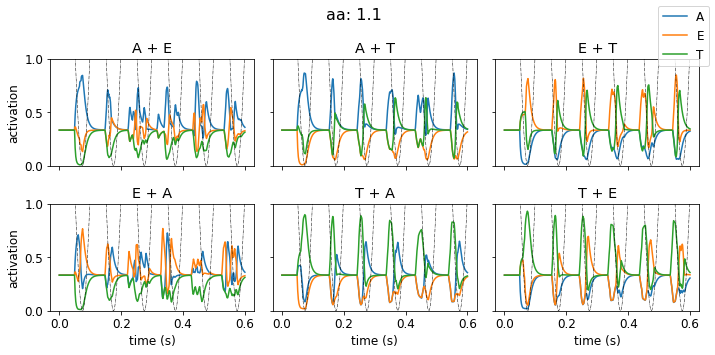

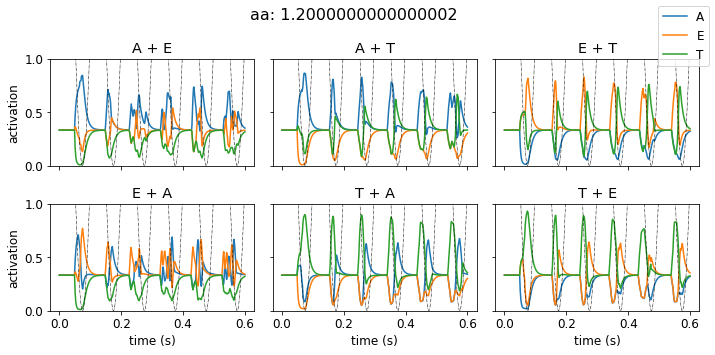

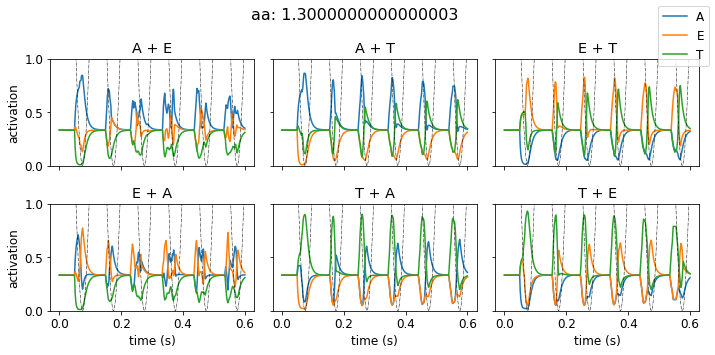

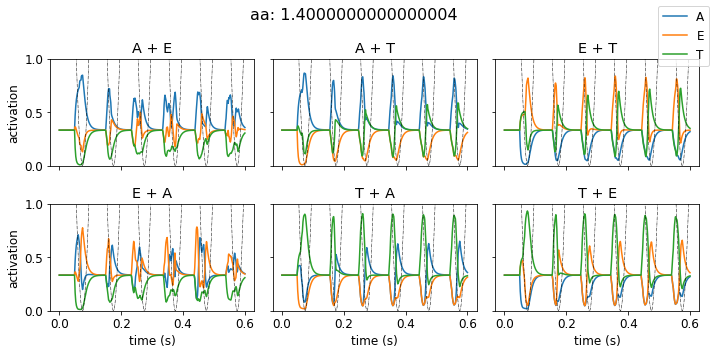

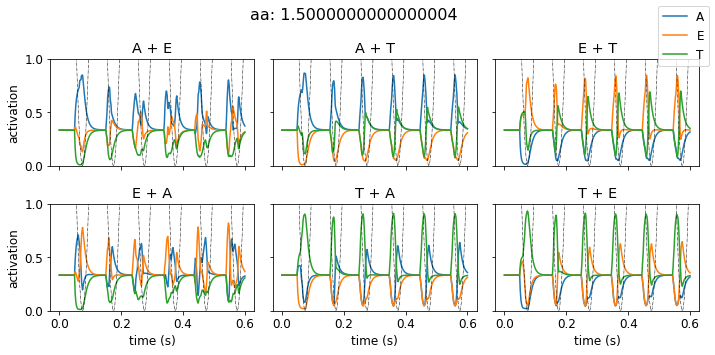

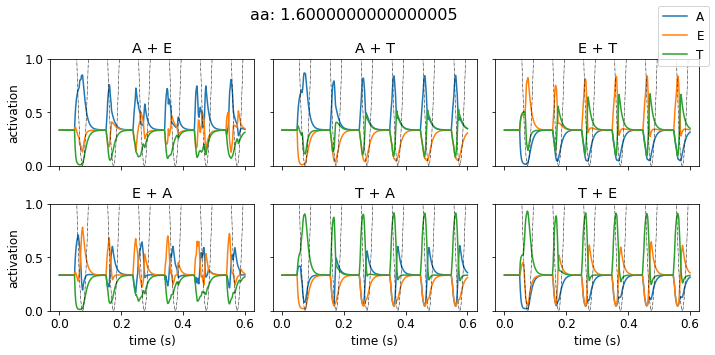

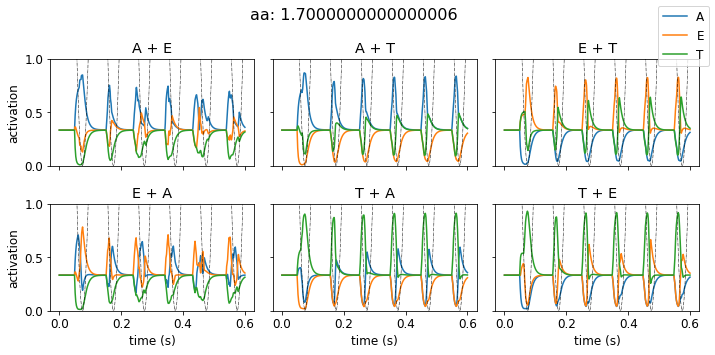

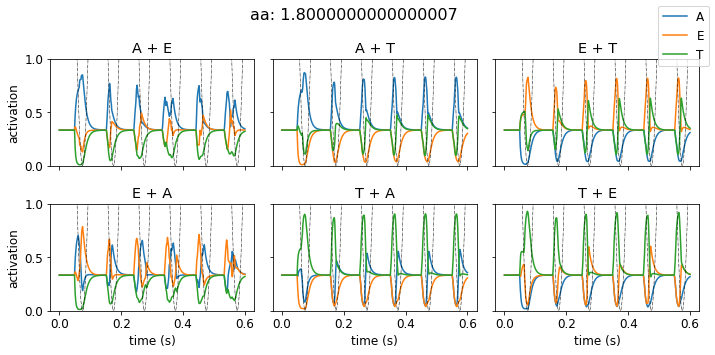

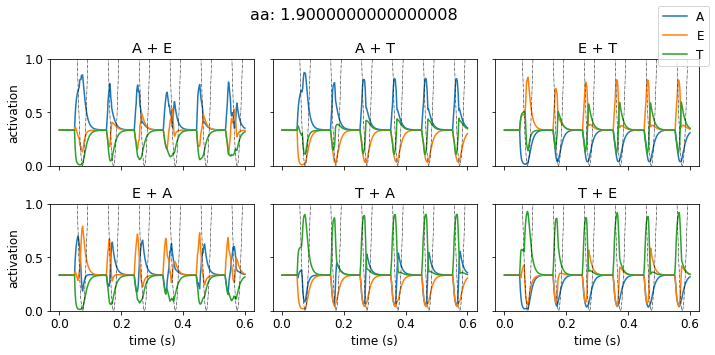

In [15]:
a = 7
for aa in np.arange(1,2,.1):
    alpha_params = [10,aa]
    dyn_params = [0.01,0.1,a,0.05,0,0]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
    _io = 50
    timevec = np.linspace(0,0.6,600)

    fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
    #ax = ax.ravel()
    plt.setp(ax,yticks=np.arange(0,1.5,0.5))

    ax[0][0].set_ylabel('activation')
    ax[1][0].set_ylabel('activation')

    alpha_inh = alpha_params[1]*np.sin(2*np.pi*timevec*alpha_params[0])+alpha_params[1]

    inp_combi = list(combinations(idx,2))           # possible input combinations
    x_train = data

    fig.suptitle('aa: '+ str(aa), fontsize=16)

    for i,comp_inp in enumerate(inp_combi):
        input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
        _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

        ax[0][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)

        if alpha_params[1]:
            ax[0][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
        ax[0][i].set_ylim((0,1))
        fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
        ax[0][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])

    for i,comp_inp in enumerate(inp_combi):
        input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
        _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

        ax[1][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
        if alpha_params[1]:
            ax[1][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
        ax[1][i].set_ylim((0,1))
        fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
        ax[1][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
        ax[1][i].set_xlabel('time (s)')

    fig.legend((label))
    fig.tight_layout()

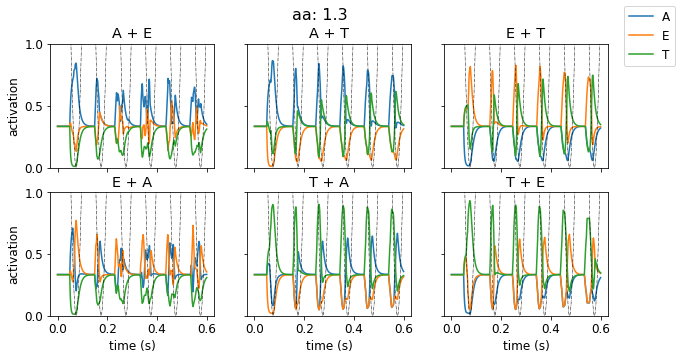

In [16]:
a = 7
aa = 1.3
alpha_params = [10,aa]
dyn_params = [0.01,0.1,a,0.05,0,0]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
_io = 50
timevec = np.linspace(0,0.6,600)

fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
#ax = ax.ravel()
plt.setp(ax,yticks=np.arange(0,1.5,0.5))

ax[0][0].set_ylabel('activation')
ax[1][0].set_ylabel('activation')

alpha_inh = alpha_params[1]*np.sin(2*np.pi*timevec*alpha_params[0])+alpha_params[1]

inp_combi = list(combinations(idx,2))           # possible input combinations
x_train = data

fig.suptitle('aa: '+ str(aa), fontsize=16)

for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
    _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

    ax[0][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)

    if alpha_params[1]:
        ax[0][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
    ax[0][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])

for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
    _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

    ax[1][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
    if alpha_params[1]:
        ax[1][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[1][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
    ax[1][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
    ax[1][i].set_xlabel('time (s)')

fig.legend((label))

plt.savefig('temp_code_a_'+str(a)+'_aa_'+str(aa)+'_tau_'+str(dyn_params[0])+'.png')


In [17]:
inp_combi

[(0, 5), (0, 10), (5, 10)]

In [18]:
#Tangledness of representations
all_angle_sum = torch.zeros(len(inp_combi))

for i,c in enumerate(inp_combi):
    
    H1 = data[c[0]]
    H2 = data[c[1]]
    H3 = data[c[0]]+data[c[1]]

    # apply layer
    H1 = model.CONV_QCOMP.forward(H1)
    H2 = model.CONV_QCOMP.forward(H2)
    H3 = model.CONV_QCOMP.forward(H3)
        
    H1_2 = H1+H2


    num_ = torch.matmul(H3,H1_2)
    denom_ = torch.linalg.vector_norm(H3)*torch.linalg.vector_norm(H1_2)
    all_angle_sum[i] = (torch.acos(num_/denom_)*180/torch.pi).cpu().detach()

In [19]:
all_angle_sum

tensor([24.7675, 20.9270, 10.4720])

In [20]:
# a = 3
# aa = 0.6

# for tau_h in np.arange(0.01,0.03,0.001):
#     alpha_params = [10,aa]
#     dyn_params = [tau_h,tau_h*5,a,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
#     _io = 50
#     timevec = np.linspace(0,0.6,600)

#     fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
#     #ax = ax.ravel()
#     plt.setp(ax,yticks=np.arange(0,1.5,0.5))

#     ax[0][0].set_ylabel('activation')
#     ax[1][0].set_ylabel('activation')

#     alpha_inh = alpha_params[1]*np.sin(2*np.pi*timevec*alpha_params[0])+alpha_params[1]

#     inp_combi = list(combinations(idx,2))           # possible input combinations
#     x_train = data

#     fig.suptitle('tau_h: '+ str(tau_h), fontsize=16)

#     for i,comp_inp in enumerate(inp_combi):
#         input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
#         _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

#         ax[0][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)

#         if alpha_params[1]:
#             ax[0][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
#         ax[0][i].set_ylim((0,1))
#         fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
#         ax[0][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])

#     for i,comp_inp in enumerate(inp_combi):
#         input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
#         _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

#         ax[1][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
#         if alpha_params[1]:
#             ax[1][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
#         ax[1][i].set_ylim((0,1))
#         fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
#         ax[1][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
#         ax[1][i].set_xlabel('time (s)')

#     fig.legend((label))
#     fig.tight_layout()

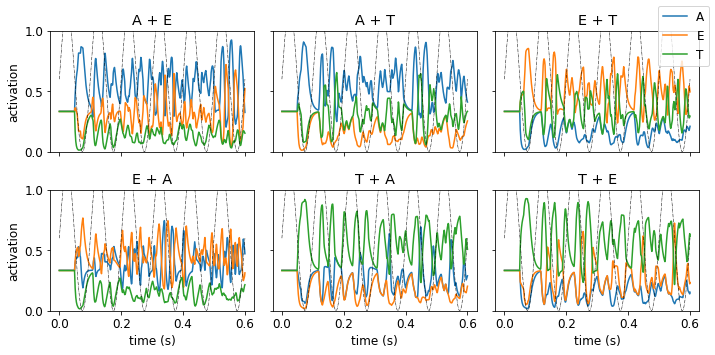

In [21]:
#start value for R does not matter too much
a = 3
aa = 0.6
tau_h = 0.01

r = 1
alpha_params = [10,aa]
dyn_params = [tau_h,tau_h*5,a,0.05,0,r]   # [tau_h, tau_r, r_scale factor, T, h start, R start]
_io = 50
timevec = np.linspace(0,0.6,600)

fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
#ax = ax.ravel()
plt.setp(ax,yticks=np.arange(0,1.5,0.5))

ax[0][0].set_ylabel('activation')
ax[1][0].set_ylabel('activation')

alpha_inh = alpha_params[1]*np.sin(2*np.pi*timevec*alpha_params[0])+alpha_params[1]

inp_combi = list(combinations(idx,2))           # possible input combinations
x_train = data

#fig.suptitle('r start: '+ str(r), fontsize=16)

for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
    _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

    ax[0][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)

    if alpha_params[1]:
        ax[0][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
    ax[0][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])

for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
    _,_,_,O_t = euler_dyn(model,lay_size_,input_,dyn_params,timevec,alpha_params,DEVICE,_io)

    ax[1][i].plot(timevec,O_t[:,1:].cpu().detach().numpy().T)
    if alpha_params[1]:
        ax[1][i].plot(timevec,alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[1][i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
    ax[1][i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
    ax[1][i].set_xlabel('time (s)')

fig.legend((label))
fig.tight_layout()

plt.savefig('dyn_temp_code.png')
